In [1]:
#pip install torch torchvision

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [3]:
# SimCLR Augmentations
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.ToTensor()
])

# Dataset wrapper for contrastive pairs
class SimCLRDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        x, _ = self.dataset[index]
        return simclr_transform(x), simclr_transform(x)

    def __len__(self):
        return len(self.dataset)

In [4]:
class SimCLRModel(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        base_model = models.resnet50(pretrained=False)

        # Remove the final FC layer and keep only the encoder
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Identity()  # No classification layer

        self.encoder = base_model

        # Add projection head (MLP)
        self.projector = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)  
        z = self.projector(h)
        return F.normalize(z, dim=1)

In [5]:
def contrastive_loss(z1, z2, temperature=0.5):
    N = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

    labels = torch.arange(N).repeat(2)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(z.device)
    mask = torch.eye(2 * N).bool().to(z.device)
    labels = labels[~mask].view(2 * N, -1)

    sim = sim[~mask].view(2 * N, -1) / temperature
    loss = -torch.log((torch.exp(sim) * labels).sum(1) / torch.exp(sim).sum(1))
    return loss.mean()

In [6]:
dataset_path = "/kaggle/input/eurosat-dataset/EuroSAT"

eurosat_raw = datasets.ImageFolder(root=dataset_path, transform=lambda x: x)
simclr_dataset = SimCLRDataset(eurosat_raw)
train_loader = DataLoader(simclr_dataset, batch_size=64, shuffle=True, num_workers=2)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Track pretext losses per epoch
pretext_losses = []

# Create SimCLR model and optimizer
model = SimCLRModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

epochs = 50

# SimCLR Pretext Training Loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x1, x2 in train_loader:
        x1, x2 = x1.to(device), x2.to(device)
        z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Loss: 3.7749
Epoch [2/50], Loss: 3.5503
Epoch [3/50], Loss: 3.4790
Epoch [4/50], Loss: 3.4444
Epoch [5/50], Loss: 3.4220
Epoch [6/50], Loss: 3.3996
Epoch [7/50], Loss: 3.3831
Epoch [8/50], Loss: 3.3669
Epoch [9/50], Loss: 3.3452
Epoch [10/50], Loss: 3.3306
Epoch [11/50], Loss: 3.3154
Epoch [12/50], Loss: 3.3069
Epoch [13/50], Loss: 3.2994
Epoch [14/50], Loss: 3.2852
Epoch [15/50], Loss: 3.2827
Epoch [16/50], Loss: 3.2726
Epoch [17/50], Loss: 3.2652
Epoch [18/50], Loss: 3.2612
Epoch [19/50], Loss: 3.2560
Epoch [20/50], Loss: 3.2518
Epoch [21/50], Loss: 3.2480
Epoch [22/50], Loss: 3.2435
Epoch [23/50], Loss: 3.2381
Epoch [24/50], Loss: 3.2344
Epoch [25/50], Loss: 3.2260
Epoch [26/50], Loss: 3.2272
Epoch [27/50], Loss: 3.2233
Epoch [28/50], Loss: 3.2179
Epoch [29/50], Loss: 3.2166
Epoch [30/50], Loss: 3.2134
Epoch [31/50], Loss: 3.2078
Epoch [32/50], Loss: 3.2108
Epoch [33/50], Loss: 3.2073
Epoch [34/50], Loss: 3.2008
Epoch [35/50], Loss: 3.2005
Epoch [36/50], Loss: 3.1988
E

In [9]:
import os
save_dir = '/kaggle/working' 
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'simclr_encoder_eurosat.pth')
torch.save(model.state_dict(), model_path)
print(f"Encoder model saved at: {model_path}")

Encoder model saved at: /kaggle/working/simclr_encoder_eurosat.pth


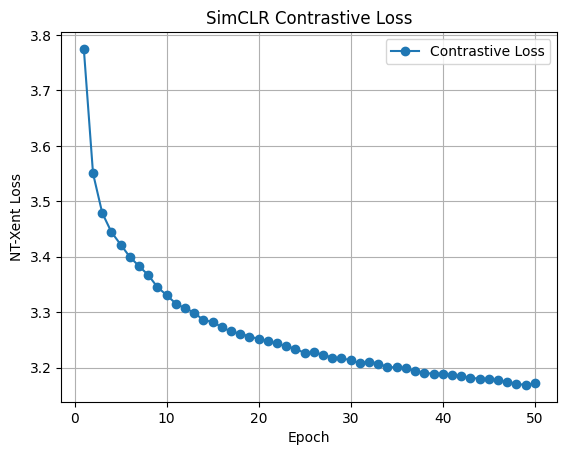

In [10]:
# SimCLR pretext loss curve
plt.plot(range(1, epochs + 1), pretext_losses, marker='o', label='Contrastive Loss')
plt.title('SimCLR Contrastive Loss')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
model = SimCLRModel().to(device)
model_path = '/kaggle/working/simclr_encoder_eurosat.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
print("Pretrained encoder loaded.")

Pretrained encoder loaded.


In [12]:
# Freeze encoder weights
for param in model.encoder.parameters():
    param.requires_grad = False

# Define classifier
classifier = nn.Linear(2048, 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)

# Prepare labeled dataset
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
eurosat = datasets.ImageFolder("/kaggle/input/eurosat-dataset/EuroSAT", transform=transform)

train_len = int(0.8 * len(eurosat))
val_len = len(eurosat) - train_len
train_ds, val_ds = random_split(eurosat, [train_len, val_len])
train_loader_cls = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader_cls = DataLoader(val_ds, batch_size=64, shuffle=False)

# Train downstream classifier
downstream_losses = []
downstream_accuracies = []

for epoch in range(50):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0

    for imgs, labels in train_loader_cls:
        imgs, labels = imgs.to(device), labels.to(device)

        # Extract frozen features
        with torch.no_grad():
            features = model.encoder(imgs)

        outputs = classifier(features)
        loss = criterion(outputs, labels)

        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Downstream Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")
    downstream_losses.append(total_loss)
    downstream_accuracies.append(acc)

Epoch 1: Downstream Loss = 139.4451, Accuracy = 86.34%
Epoch 2: Downstream Loss = 120.5012, Accuracy = 88.30%
Epoch 3: Downstream Loss = 113.3581, Accuracy = 89.08%
Epoch 4: Downstream Loss = 103.2053, Accuracy = 89.89%
Epoch 5: Downstream Loss = 102.0568, Accuracy = 90.16%
Epoch 6: Downstream Loss = 99.0934, Accuracy = 90.32%
Epoch 7: Downstream Loss = 99.2858, Accuracy = 90.57%
Epoch 8: Downstream Loss = 91.7238, Accuracy = 90.95%
Epoch 9: Downstream Loss = 97.6174, Accuracy = 90.64%
Epoch 10: Downstream Loss = 89.9362, Accuracy = 91.16%
Epoch 11: Downstream Loss = 89.4251, Accuracy = 91.15%
Epoch 12: Downstream Loss = 87.2427, Accuracy = 91.44%
Epoch 13: Downstream Loss = 84.2766, Accuracy = 91.56%
Epoch 14: Downstream Loss = 85.2541, Accuracy = 91.68%
Epoch 15: Downstream Loss = 87.6564, Accuracy = 91.62%
Epoch 16: Downstream Loss = 80.3712, Accuracy = 91.97%
Epoch 17: Downstream Loss = 81.7995, Accuracy = 91.99%
Epoch 18: Downstream Loss = 81.2026, Accuracy = 92.19%
Epoch 19: Down

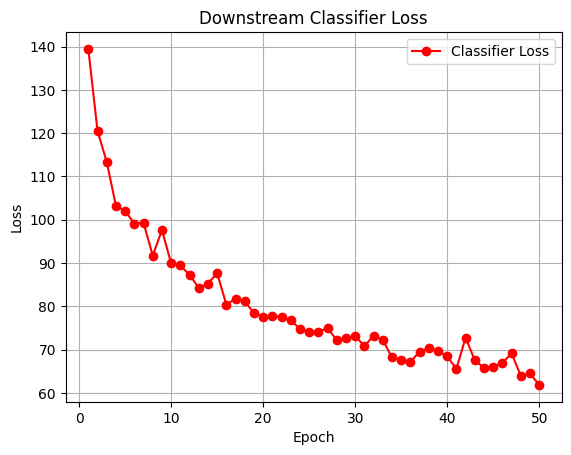

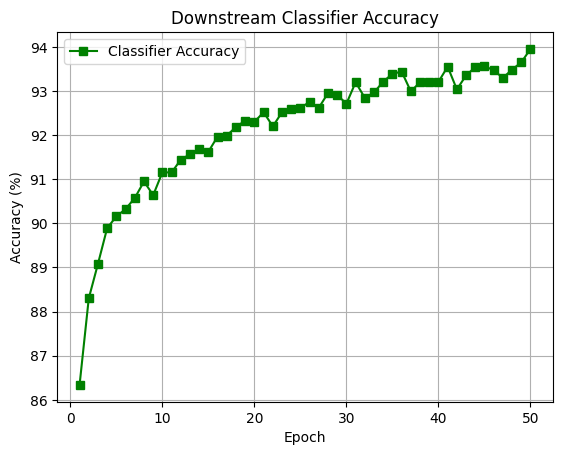

In [13]:
plt.plot(range(1, len(downstream_losses)+1), downstream_losses, marker='o', color='red', label='Classifier Loss')
plt.title('Downstream Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_accuracies)+1), downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Downstream Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()